## Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [2]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import os
%matplotlib inline
import matplotlib.pyplot as plt
import random
from skimage import io, transform
from torchvision import utils
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from skimage.io import imread
import time

In [3]:
torch.cuda.set_device(2) #Set according to device. 

All hyper parameters go in the next block

In [4]:
batch_size = 10
num_epochs = 5
learning_rate = 0.0001

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [5]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        if(self.train):
            data_dir = os.path.join(self.root_dir, 'train')
        else:
            data_dir = os.path.join(self.root_dir, 'test')
#        self.mapping = {}
        self.mlist = list()
        
        for root, dirs, files in os.walk(data_dir):
            path = root.split(os.sep)
            lab = os.path.basename(root)
            for file in files:
                self.mlist.append(file +'LAB'+ str(ord(lab) - ord('A')))
#                if ord(lab) - ord('A') not in self.mapping.keys():
#                    self.mapping[ord(lab) - ord('A')] = list()
#                self.mapping[ord(lab) - ord('A')].append(file)

    def __len__(self):
        return len(self.mlist)
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        name = self.mlist[idx]
        file = name[:-4]
        label = int(name[-1])
        
        if(self.train):
            data_dir = os.path.join(self.root_dir, 'train')
        else:
            data_dir = os.path.join(self.root_dir, 'test')
        
        img_name = os.path.join(data_dir , chr(ord('A') + label), file)
        image = io.imread(img_name,as_grey = False)
        image = np.repeat(image[:, :,np.newaxis], 3, axis=2)
        #image = image.reshape(image.shape[0],image.shape[1],1)
        #print(image.shape)
        
        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        
        if self.transform:
            image = self.transform(image)
        return (image,label)

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
Train images


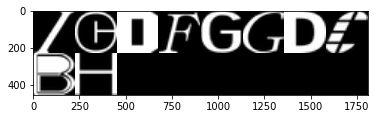

In [6]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./notMNIST_small/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='./notMNIST_small/', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)

train_images, train_labels = train_dataiter.next()
print("Train images")
imshow(utils.make_grid(train_images))


Test images


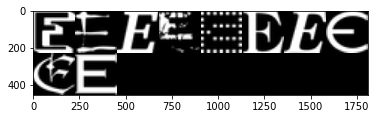

In [7]:
test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [8]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Code to change the last layers so that they only have 10 classes as output
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Add code for using CUDA here if it is available
if(torch.cuda.is_available()):
    vgg16.cuda()
    #resnet18.cuda()

Define loss functions and optimizers

In [14]:
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer =  optim.Adam(vgg16.parameters(), lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter


#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [18]:
def train(model,num_epochs):
    stats = {'epoch_loss':list(),'trainacc':list(),'testacc':list()}
    
    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            if(torch.cuda.is_available()):
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
           
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

        end = time.time()
       
        print('Epoch #',epoch,'Loss per batch: ',round(running_loss/len(train_loader),2),'Time in this epoch: ',round(end-start,2))
        
        stats['epoch_loss'].append(round(running_loss/len(train_loader),2))
        
        start = time.time()
        
        print('Test')
        stats['testacc'].append(test(model, False))
        
        print('Training')
        stats['trainacc'].append(test(model, True))
    
    print('Finished Training')
    return stats

def test(model,training):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    tot = right = 0
    if(training == False):
        x = test_loader
    else:
        x = train_loader
    for data in x:
        images, labels = data
        images, labels = images.cuda(),labels.cuda()
        images, labels = Variable(images, volatile = True), Variable(labels)
        outputs = model(images)
        q , predicted = torch.max(outputs.data, 1)

        predicted = predicted.cpu()
        labels = labels.data.cpu()
        right += (predicted == labels).sum()
        tot += labels.size(0)
    print('Accuracy :', 100*right/tot)
    return right/tot

Now let us start the training/finetuning

# Observations on Training VGG16:
    
I used the suggested **ADAM optimizer** with the on a single **Titan X GPU with 12 GB RAM**. Following are the results observed:

<table>
  <tr><th>Batch Size</th><th>Learning Rate</th><th>Training CE loss (Epoch Wise)</th><th>Test Accuracy (Epoch Wise)</th><th>Remarks</th>
  </tr>
  <tr><th>10</th><th>1e-4</th><th>0.29: *1* ; 0.17 : *2* ; 0.12 : *3* ; 0.09 : *4* ; 0.06 : *5* ; 0.057 : *6* ;  </th><th>94.22 : *1* ; 93.15 : *2* ; 94.7 : *3* ; 95.9 : *4* ; 95.5 :*5* ;  95.7 :*6* ; </th><th> </th>
</table>


In [19]:
stats = train(vgg16,num_epochs)

Epoch # 0 Loss per batch:  0.29 Time in this epoch:  280.43
Test
Accuracy : 93.31550802139037
Training
Accuracy : 94.81428740951704
Epoch # 1 Loss per batch:  0.16 Time in this epoch:  286.73
Test
Accuracy : 94.33155080213903
Training
Accuracy : 96.45188085914323
Epoch # 2 Loss per batch:  0.12 Time in this epoch:  278.37
Test
Accuracy : 94.43850267379679
Training
Accuracy : 96.77821288714846
Epoch # 3 Loss per batch:  0.09 Time in this epoch:  299.88
Test
Accuracy : 94.75935828877006
Training
Accuracy : 97.79280882876469
Epoch # 4 Loss per batch:  0.07 Time in this epoch:  307.73
Test
Accuracy : 95.3475935828877
Training
Accuracy : 98.5997389343776
Finished Training


#### Testing
Once finetuning is done we need to test it on the test set.

Test the models

Plot for Epoch Loss


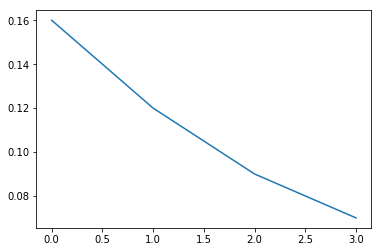

Plot for training and testing accuracy


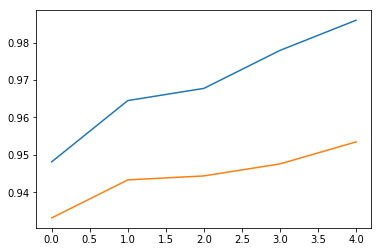

In [20]:
print('Plot for Epoch Loss')
plt.plot(stats['epoch_loss'][1:]) #To ignore the abnormal improvement in 1s epoch for a clear graph.
plt.show()
print('Plot for training and testing accuracy')
plt.plot(stats['trainacc'])
plt.plot(stats['testacc'])
plt.show()

The graphs indicate that the training has **not saturated**. So, using additional 2 epochs for training. 

In [21]:
stats = train(vgg16,3)

Epoch # 0 Loss per batch:  0.06 Time in this epoch:  310.43
Test
Accuracy : 94.59893048128342
Training
Accuracy : 98.10727423756971
Epoch # 1 Loss per batch:  0.06 Time in this epoch:  302.41
Test
Accuracy : 95.02673796791444
Training
Accuracy : 98.29714014477275
Epoch # 2 Loss per batch:  0.05 Time in this epoch:  302.99
Test
Accuracy : 95.88235294117646
Training
Accuracy : 98.88453779518215
Finished Training


# SUMMARY

After 8 epochs  we achieve the maximum test accuracy of **95.8%**.

You can add more code to save the models if you want but otherwise this notebook is complete